# Introduction

This notebook shows how to use SigOpt to optimize a rasa NLU model for intent classification.

# Libraries

In [1]:
import nest_asyncio

nest_asyncio.apply()


In [2]:
import tempfile

import rasa.shared.data as data
import sigopt
from rasa.engine.recipes.recipe import Recipe
from rasa.model_testing import test_core, test_nlu
from rasa.model_training import (
    DaskGraphRunner,
    GraphTrainer,
    LocalTrainingCache,
    Path,
    TrainingResult,
    _create_model_storage,
    _determine_model_name,
)
from rasa.shared.importers.autoconfig import TrainingType
from rasa.shared.importers.importer import TrainingDataImporter
import json
import time
import asyncio


2022-01-07 15:14:41.369723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-07 15:14:41.369779: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Setup 

Setup sigopt:

In [3]:
!sigopt config --api-token $SIGOPT_API_TOKEN --enable-log-collection --enable-cell-tracking

In [4]:
%load_ext sigopt

Move to the bot's root directory:

In [5]:
%cd ../bot_sigopt

/workspaces/rasa_sigopt/bot_sigopt


Define paths to rasa configs:

In [6]:
CONFIG = "config.yml"
TRAINING_FILES = "data"
VALIDATION_FILES = "tests"
DOMAIN = "domain.yml"
MODELS = "models"
TEST_RESULTS = "results"


# Utility Functions

Define a function to do the training:

In [7]:
def train(config, file_importer, output_path="models", training_type=TrainingType.BOTH):
    recipe = Recipe.recipe_for_name(config.get("recipe"))
    model_configuration = recipe.graph_config_for_recipe(
        config,
        cli_parameters={},
        training_type=training_type,
    )

    with tempfile.TemporaryDirectory() as temp_model_dir:
        model_storage = _create_model_storage(
            is_finetuning=False,
            model_to_finetune=None,
            temp_model_dir=Path(temp_model_dir),
        )
        cache = LocalTrainingCache()
        trainer = GraphTrainer(model_storage, cache, DaskGraphRunner)

        model_name = _determine_model_name(
            fixed_model_name=None, training_type=training_type
        )

        full_model_path = Path(output_path, model_name)

        trainer.train(
            model_configuration,
            file_importer,
            full_model_path,
            force_retraining=False,
            is_finetuning=False,
        )

        return TrainingResult(str(full_model_path), 0)


Define a function to extract some metrics from the test: 

In [8]:
def extract_metric(file):
    with open(file, "r") as f:
        metrics = json.load(f)

    return metrics["weighted avg"]["f1-score"]


Define a function to get the config for the DIET Classifier from a config:

In [9]:
get_diet_config = lambda config: [
    component
    for component in config["pipeline"]
    if component["name"] == "DIETClassifier"
][0]


## Demo

Define a function that will train and evaluate and nlu model given the hyperparameters:

In [10]:
async def train_and_evaluate_nlu_model(config, file_importer, validation_path):
    start_time = time.time()

    nlu_training_results = train(config, file_importer, training_type=TrainingType.NLU)

    model_path = nlu_training_results.model

    with tempfile.TemporaryDirectory() as temp_results_dir:
        await test_nlu(
            model=model_path,
            nlu_data=validation_path,
            output_directory=temp_results_dir,
            additional_arguments={},
        )

        f1_intent = extract_metric(f"{temp_results_dir}/intent_report.json")
        f1_entity = extract_metric(f"{temp_results_dir}/DIETClassifier_report.json")

    end_time = time.time()

    return {
        "f1_intent": f1_intent,
        "f1_entity": f1_entity,
        "elapsed_time": end_time - start_time,
    }


Define a function to instrument the `train_and_evaluate_nlu_model` function in sigopt:

In [11]:
async def run_and_track_in_sigopt():
    sigopt.log_dataset("Ask Ubuntu Corpus")
    sigopt.log_model("Default NLU Pipeline")
    file_importer = TrainingDataImporter.load_from_config(
        CONFIG, DOMAIN, TRAINING_FILES
    )

    all_config = file_importer.get_config()
    diet_config = get_diet_config(all_config)

    sigopt.params.setdefault("epochs")
    sigopt.params.setdefault("embedding_dimension")
    sigopt.params.setdefault("number_of_transformer_layers")
    sigopt.params.setdefault("transformer_size")

    diet_config["epochs"] = sigopt.params.epochs
    diet_config["embedding_dimension"] = sigopt.params.embedding_dimension
    diet_config[
        "number_of_transformer_layers"
    ] = sigopt.params.number_of_transformer_layers
    diet_config["transformer_size"] = int(sigopt.params.transformer_size)

    results = await train_and_evaluate_nlu_model(
        all_config, file_importer, VALIDATION_FILES
    )

    sigopt.log_metric(name="f1-score (intent)", value=results["f1_intent"])
    sigopt.log_metric(name="f1-score (entity)", value=results["f1_entity"])
    sigopt.log_metric(name="total time (s)", value=results["elapsed_time"])


Define the experiment configuration:

In [12]:
%%experiment
{
    'name': 'NLU Optimization on Ask Ubuntu Corpus - Intent Classification',
    'type': 'offline',
    'metrics': [
        {
            'name': 'f1-score (intent)',
            'strategy': 'optimize',
            'objective': 'maximize',
        }
    ],
    'parameters': [
        {
            'name': 'epochs',
            'type': 'int',
            'bounds': {'min': 1, 'max': 1000}
        },
        {
            'name': 'embedding_dimension',
            'type': 'int',
            'bounds': {'min': 16, 'max': 1024}
        },
        {
            'name': 'number_of_transformer_layers',
            'type': 'int',
            'bounds': {'min': 0, 'max': 8}
        },
        {
            'name': 'transformer_size',
            'type': 'categorical',
            'categorical_values': ['4', '16', '64', '256', '1024']
        },
    ],
    'budget': 3,
    'parallel_bandwidth': 1
}

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/473806


Run the optimization:

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/142063


/opt/venv/lib/python3.8/site-packages/rasa/shared/core/slot_mappings.py:212: UserWarning: Slot auto-fill has been removed in 3.0 and replaced with a new explicit mechanism to set slots. Please refer to https://rasa.com/docs/rasa/domain#slots to learn more.
  rasa.shared.utils.io.raise_warning(
/opt/venv/lib/python3.8/site-packages/rasa/utils/tensorflow/model_data_utils.py:396: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([v[0] for v in values]), number_of_dimensions=3
2022-01-07 15:14:58.222678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-07 15:14:58.222736: W tensorflow/stream_executor/cuda/cuda_driver.cc

Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/142063
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/142066


/opt/venv/lib/python3.8/site-packages/rasa/shared/core/slot_mappings.py:212: UserWarning: Slot auto-fill has been removed in 3.0 and replaced with a new explicit mechanism to set slots. Please refer to https://rasa.com/docs/rasa/domain#slots to learn more.
  rasa.shared.utils.io.raise_warning(
/opt/venv/lib/python3.8/site-packages/rasa/utils/tensorflow/model_data_utils.py:396: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([v[0] for v in values]), number_of_dimensions=3
/opt/venv/lib/python3.8/site-packages/rasa/utils/tensorflow/model_data.py:750: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must s

Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/142066
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/142067


/opt/venv/lib/python3.8/site-packages/rasa/shared/core/slot_mappings.py:212: UserWarning: Slot auto-fill has been removed in 3.0 and replaced with a new explicit mechanism to set slots. Please refer to https://rasa.com/docs/rasa/domain#slots to learn more.
  rasa.shared.utils.io.raise_warning(
/opt/venv/lib/python3.8/site-packages/rasa/utils/tensorflow/model_data_utils.py:396: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([v[0] for v in values]), number_of_dimensions=3
/opt/venv/lib/python3.8/site-packages/rasa/utils/tensorflow/model_data.py:750: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must s

Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/142067


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

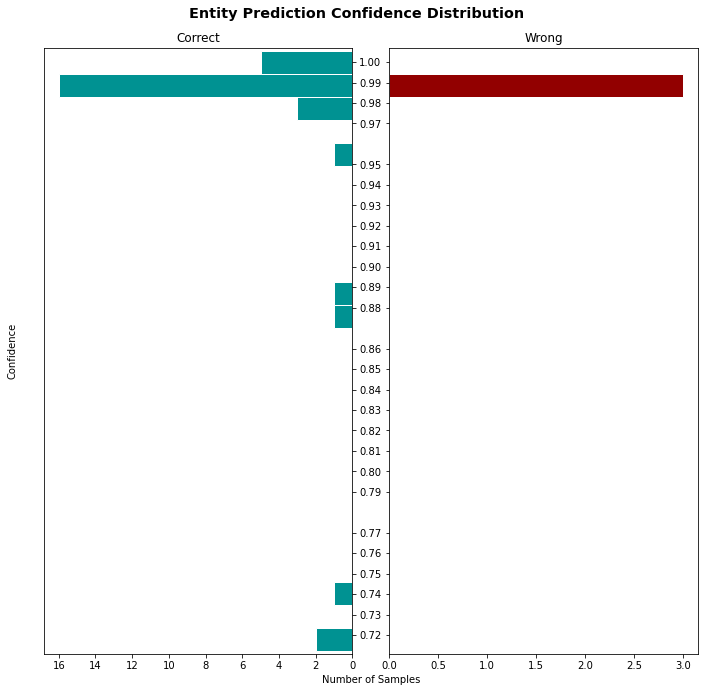

In [13]:
%%optimize Intent Classification Optimization

loop = asyncio.get_event_loop()
loop.run_until_complete(run_and_track_in_sigopt())